<a href="https://colab.research.google.com/drive/1CPNByQ_lHLm6SAXL9FhjaBUCIXvItHmi?usp=chrome_ntp#scrollTo=gw7hnqUKeVgD&uniqifier=1" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SI-VAE analysis on PFM scan of PTO sample
- Author - Utkarsh Pratiush (https://scholar.google.com/citations?user=BqhnGGAAAAAJ&hl=en),
Aditya Raghavan (https://scholar.google.com/citations?hl=en&user=17I084UAAAAJ) and
Mani Valleti (https://scholar.google.com/citations?user=Jt7c5d4AAAAJ&hl=en)
- Idea - Sergei Kalinin (https://scholar.google.com/citations?user=-cuxoSQAAAAJ&hl=en)

SPM data collected by Yongtao Liu (https://scholar.google.com/citations?hl=en&user=V9FMPgQAAAAJ&view_op=list_works&sortby=pubdate) at CNMS

Sample  - PTO made by Funakubo Laboratory (https://f-lab.iem.titech.ac.jp/homeen/)


## some installations and imports

Run the igor 2 installation, restart session and then run all

In [ ]:
#Installing SciFiReaders to read Igor files
!pip install SciFiReaders igor2
#AFTER THIS CELL RESTART RUNTIME ELSE It WILL NOT WORK

In [ ]:
# Installing Kornia and pyroved
!pip install -q kornia atomai git+https://github.com/ziatdinovmax/pyroVED@main

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 833.3/833.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.1/274.1 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 5.5 MB/s eta 0:00:00


In [ ]:
#Install Atom AI
!pip install --upgrade git+https://github.com/ziatdinovmax/atomai.git;

  Cloning https://github.com/ziatdinovmax/atomai.git to /tmp/pip-req-build-hv0ipjxq
  Running command git clone --filter=blob:none --quiet https://github.com/ziatdinovmax/atomai.git /tmp/pip-req-build-hv0ipjxq
  Resolved https://github.com/ziatdinovmax/atomai.git to commit 3e4c005a31d7585a7fdfe5dfbd66f7fd726258ed
  Preparing metadata (setup.py) ... done


In [ ]:
# Importing necessary packages
import torch
from torchvision.utils import make_grid
import torch.nn as nn

from tqdm import tqdm
import pyroved as pv
import kornia as K

# We will use atomai just to create the dataset (sub-images)
import atomai as aoi
from atomai import utils

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import cv2
import seaborn as sns
from scipy import stats
tt = torch.tensor

import SciFiReaders

import matplotlib
matplotlib.rcParams['axes.linewidth'] = 2

In [ ]:
def normalize(data):
  if data.ndim == 2:
    return (data - np.min(data))/(np.ptp(data))
  elif data.ndim == 3:
    norm_imgs = np.zeros_like(data)
    for i in range(len(data)):
      norm_imgs[i] = (data[i] - np.min(data[i]))/(np.ptp(data[i]))
    return norm_imgs

## get data

In [ ]:
# reference notebook: https://github.com/saimani5/VAE-tutorials/blob/main/rvae_graphene.ipynb

In [ ]:
!gdown https://drive.google.com/uc?id=17nUSurxAMgxrkUfTvxI7z3MPdlFfTHMW

Downloading...
From (original): https://drive.google.com/uc?id=17nUSurxAMgxrkUfTvxI7z3MPdlFfTHMW
From (redirected): https://drive.google.com/uc?id=17nUSurxAMgxrkUfTvxI7z3MPdlFfTHMW&confirm=t&uuid=72003281-ab10-49ff-aaad-686ee26c713c
To: /content/PTO_20240605.zip
100% 634M/634M [00:29<00:00, 21.3MB/s]


In [ ]:
!unzip /content/PTO_20240605.zip

Archive:  /content/PTO_20240605.zip
  inflating: PTO_20240605/Yongtao_BEPFM_10um.h5  
  inflating: PTO_20240605/Yongtao_BEPFM_2um.h5  
  inflating: PTO_20240605/Yongtao_BEPFM_5um.h5  
  inflating: PTO_20240605/Yongtao_sfPFM_10um.ibw  
  inflating: PTO_20240605/Yongtao_sfPFM_2um.ibw  
  inflating: PTO_20240605/Yongtao_sfPFM_5um.ibw  


# data import

In [ ]:
import os
path = "/content/PTO_20240605"
os.chdir(path)

In [ ]:
# Define a function to read single frequency PFM data
def readsfpfm (file):
  reader = SciFiReaders.IgorIBWReader(file)
  data = reader.read()
  height, amplitude, deflection, phase = data[0], data[1], data[2], data[3]
  return height, amplitude, deflection, phase

In [ ]:
sfPFM2um = "Yongtao_sfPFM_2um.ibw"
sfPFM5um = "Yongtao_sfPFM_5um.ibw"
sfPFM10um = "Yongtao_sfPFM_10um.ibw"

In [ ]:
topo, amp, defl, pha = readsfpfm(sfPFM10um)

fig, axs = plt.subplots(1, 4, figsize=(16, 4), dpi=300)
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.15)
cm = 'viridis'
shrink = 0.7

im0 = axs[0].imshow((topo-topo.min())*1E9, interpolation='nearest', cmap=cm)
fig.colorbar(im0, ax=axs[0], shrink = shrink, label = "Height (nm)")
axs[0].axis('off')

im1 = axs[1].imshow(defl*1E7, interpolation='nearest', cmap=cm)
fig.colorbar(im1, ax=axs[1], shrink = shrink, label = "Deflection (a.u.)")
axs[1].axis('off')

im2 = axs[2].imshow(amp*1E8, interpolation='nearest', cmap=cm)
fig.colorbar(im2, ax=axs[2], shrink = shrink, label = "Amplitude (a.u.)")
axs[2].axis('off')

im3 = axs[3].imshow(pha, interpolation='nearest', cmap=cm)
fig.colorbar(im3, ax=axs[3], shrink = shrink, label = "Phase (deg)")
axs[3].axis('off')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#We are choosing Amplitude for the analysis. Choose your image accordingly
image = np.array(amp*1E8)

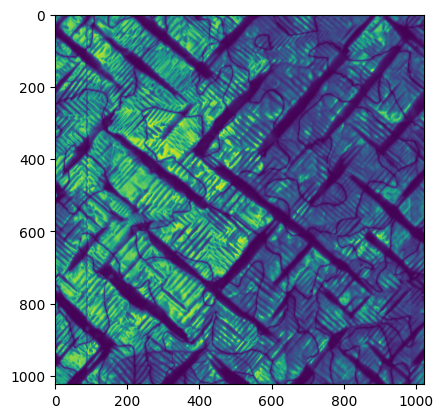

In [ ]:
plt.imshow(image)

In [ ]:
image.shape

(1024, 1024)

In [ ]:
# We want to make the image bigger to have more patches, to help in better training
resized_ht = cv2.resize(np.array(image), (2048, 2048), interpolation=cv2.INTER_NEAREST)
resized_ht = np.array(resized_ht)
print(resized_ht.shape)

(2048, 2048)


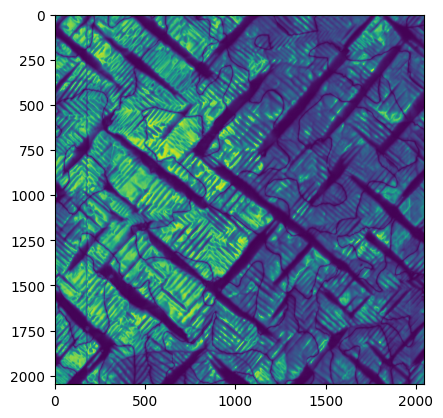

In [ ]:
plt.imshow(resized_ht)

In [ ]:
coords = utils.get_coord_grid(resized_ht, 80)
# print(coords[].shape)
patch10, _, f_num = utils.extract_subimages(resized_ht, coords, 70 )
print(patch10.shape, f_num.shape)

(625, 70, 70, 1) (625,)


## Testing Coordinates

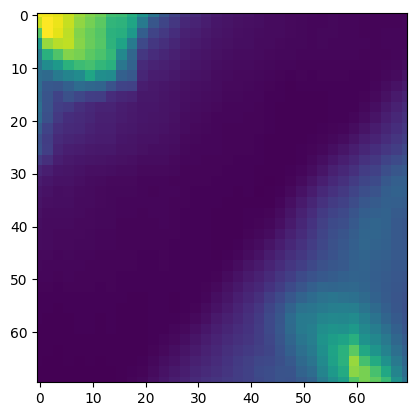

In [ ]:
plt.imshow(patch10[12,:,:])

In [ ]:
coords = utils.get_coord_grid(resized_ht, 80)
# print(coords[19].shape)
patch10, _, fn = utils.extract_subimages(resized_ht, coords, 80 )
print(patch10.shape)

(625, 80, 80, 1)


In [ ]:
original_coordinates = coords[0][:,0:2]
filtered_coordinates = np.array([coord for coord in original_coordinates if 100 <= coord[0] < 1956 and 100 <= coord[1] < 1956])

(-0.5, 2047.5, 2047.5, -0.5)

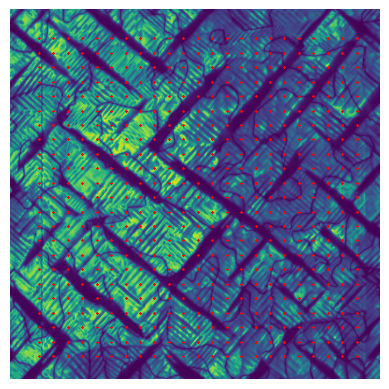

In [ ]:
filtered_coordinates
plt.imshow(resized_ht)
plt.scatter(filtered_coordinates[:,1],filtered_coordinates[:,0], s =1, marker= "x", c= 'r')
plt.axis('off')

We will be taking patches by filtering the end patches. The above figire shows the center co-ordinates of the patches we will be taking

In [ ]:
# Make Patches to visualize. This can be used to select the ws array later in the notebook.
w = 40 # window size or descriptor
patch10, _, fn = utils.extract_subimages(resized_ht, filtered_coordinates, w )
print(patch10.shape)

(529, 40, 40, 1)


Change w and visualize how it looks for different window sizes to choose a range of window sizes for the ws array.

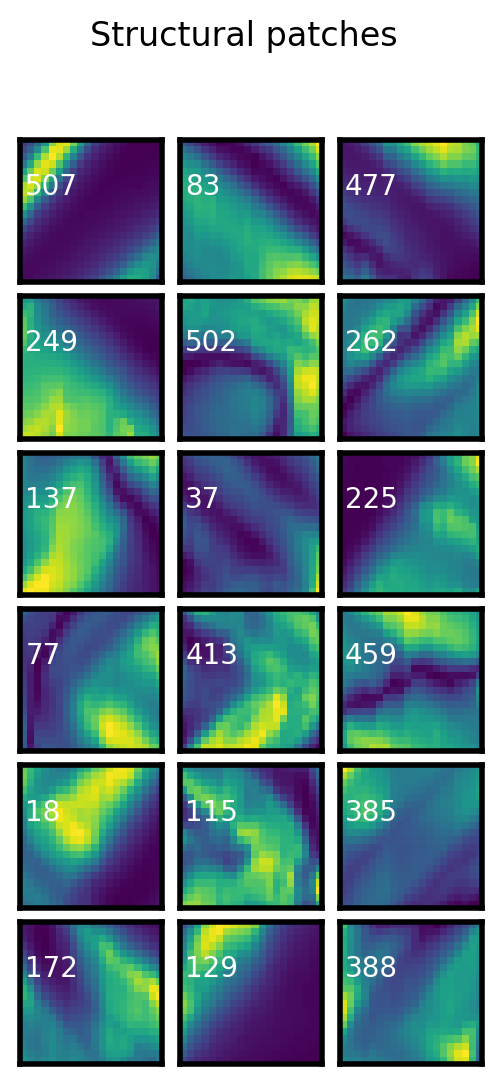

In [ ]:
# Visualize Random Patches.
#plot examples of patches
fig, axes = plt.subplots(6, 3, figsize=(3, 6), dpi = 200,
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

fig.suptitle('Structural patches')

for ax in axes.flat:
    i = np.random.randint(len(patch10))
    ax.imshow(patch10[i], interpolation='nearest')
    ax.text(1, 15, str(i), color='white')

# Preprocessing
Here we have the functions that prepare the image to go into the VAE

In [ ]:
def get_uniform_patches(img : np.ndarray, cords, w_s: int ):
  """
  Creates patches of size w_s around coords

  Args:
    img: image to make patches from: numpy array
    coords: coordinates of points around which the patches are taken
    w_s: size of patches: int

  """
  # norm_image = normalize(img)

  #extract patches for each point on a grid
  features_all, _, frame_number = utils.extract_subimages(img, cords, w_s)
  print(features_all.shape)

  return features_all, frame_number

def get_coordinates_single_patch(img : np.ndarray, w_s: np.ndarray ):
  """
  Get's coordinates for the single image for the maximum value of w_s in the array

  Args:
    img: image to make patches from: numpy array
    w_s: numpy array of window size iterating in the VAE

  """

  w_s_max = np.max(w_s) + 5
  coords = utils.get_coord_grid(img, w_s_max )
  fil_crds = []
  original_coordinates = coords[0][:,0:2]
  filtered_coordinates = np.array([coord for coord in original_coordinates if 100 <= coord[0] < 1956 and 100 <= coord[1] < 1956])

  return filtered_coordinates

def get_coordinates(img : np.ndarray, w_s: np.ndarray ):
  """
  Get's coordinates for the image stack for the maximum value of w_s in the array


  Args:
    img: image to make patches from: numpy array
    w_s: numpy array of window size iterating in the VAE

  """
  num_images= resized_ht.shape[0]
  w_s_max = np.max(w_s) + 5
  coords = utils.get_coord_grid(img, w_s_max )
  dict_coord = {}
  original_coordinates = coords[0][:,0:2]
  filtered_coordinates = np.array([coord for coord in original_coordinates if 100 <= coord[0] < 1956 and 100 <= coord[1] < 1956])
  extra_z_coordinate = np.zeros((filtered_coordinates.shape[0], 1))
  # This a hacky way to get things working ---> as atomai stem images coordinates has extra dimension for atom type. SPM images dont have such case.
  coordinates_3d = np.concatenate((filtered_coordinates, extra_z_coordinate), axis=1)

  for i in range(num_images):
        dict_coord[i] =  coordinates_3d


  return dict_coord

In [ ]:
# use to test and see if the number of patches is same accross all window sizes. can be made as a test function
"""crds = get_coordinates(resized_ht, ws)
print(crds.shape)
pach10 = get_uniform_patches(resized_ht, crds, 10)
pach30 = get_uniform_patches(resized_ht, crds, 30)
pach50 = get_uniform_patches(resized_ht,crds, 50)
print(pach10.shape, pach30.shape, pach50.shape)"""

'crds = get_coordinates(resized_ht, ws)\nprint(crds.shape)\npach10 = get_uniform_patches(resized_ht, crds, 10)\npach30 = get_uniform_patches(resized_ht, crds, 30)\npach50 = get_uniform_patches(resized_ht,crds, 50)\nprint(pach10.shape, pach30.shape, pach50.shape)'

#VAE with rotational and tranlational invariances

This is a simple VAE that considers same featurs with different rotational angles and ones at different postions to be the same. This enables to capture the variation in the underlying features more accurately

In [ ]:
ws = 80 # choose only one window size here. This is a standard VAE to demomnstrate the difference from SI-VAE

In [ ]:
co_ords = get_coordinates_single_patch(resized_ht, ws)

In [ ]:
patches, f_num = get_uniform_patches(resized_ht, co_ords, ws)

patches = normalize(np.squeeze(patches))

(484, 80, 80, 1)


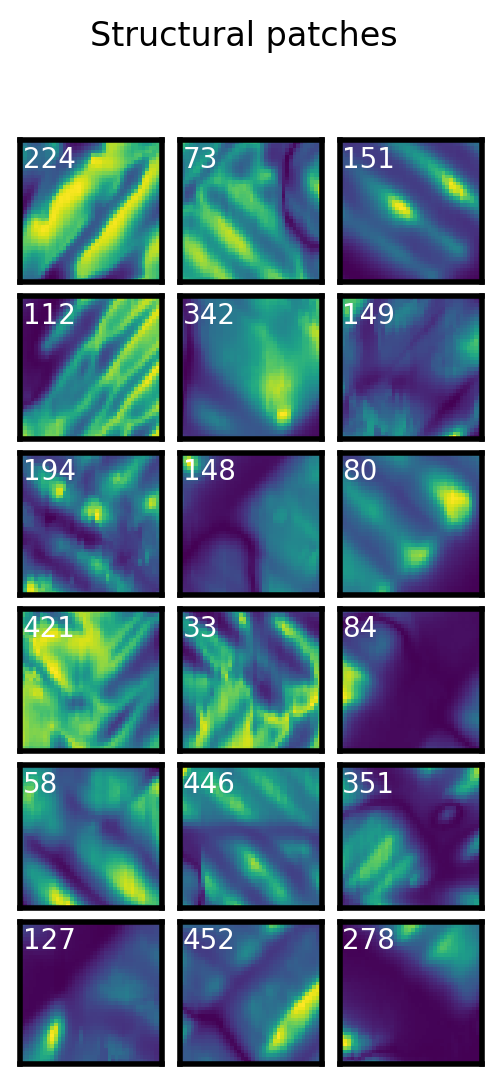

In [ ]:
#plot examples of patches
fig, axes = plt.subplots(6, 3, figsize=(3, 6), dpi = 200,
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

fig.suptitle('Structural patches')

for ax in axes.flat:
    i = np.random.randint(len(patches))
    ax.imshow(patches[i], interpolation='nearest')
    ax.text(1, 15, str(i), color='white')

In [ ]:
#construct image stack and loader for VAE
vae_data = torch.tensor(patches).float()
vae_loader = pv.utils.init_dataloader(vae_data, batch_size=120)

In [ ]:
# train VAE using the constructed stack of subimages
in_dim = (ws, ws)

vae_vanilla = pv.models.iVAE(in_dim, latent_dim=2, invariances=['r','t'],
                      sampler_d='continuous_bernoulli', seed=42)
# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae_vanilla)
training_losses = []

# Train for n epochs:
for e in range(1000):
    trainer.step(vae_loader)
    trainer.print_statistics()
    # training_loss = trainer.loss
    # training_losses.append(training_loss)

Epoch: 1 Training loss: -309.6428
Epoch: 2 Training loss: -601.2166
Epoch: 3 Training loss: -687.3271
Epoch: 4 Training loss: -830.6895
Epoch: 5 Training loss: -887.2475
Epoch: 6 Training loss: -1070.9517
Epoch: 7 Training loss: -1185.9939
Epoch: 8 Training loss: -1243.7505
Epoch: 9 Training loss: -1286.0053
Epoch: 10 Training loss: -1251.1751
Epoch: 11 Training loss: -1151.4685
Epoch: 12 Training loss: -1250.0890
Epoch: 13 Training loss: -1281.6564
Epoch: 14 Training loss: -1272.5742
Epoch: 15 Training loss: -1361.8517
Epoch: 16 Training loss: -1457.5335
Epoch: 17 Training loss: -1455.3484
Epoch: 18 Training loss: -1544.1738
Epoch: 19 Training loss: -1596.9314
Epoch: 20 Training loss: -1614.4851
Epoch: 21 Training loss: -1662.5285
Epoch: 22 Training loss: -1687.6668
Epoch: 23 Training loss: -1735.7516
Epoch: 24 Training loss: -1749.6437
Epoch: 25 Training loss: -1753.8106
Epoch: 26 Training loss: -1721.2727
Epoch: 27 Training loss: -1780.5267
Epoch: 28 Training loss: -1809.0646
Epoch:

To get meaningful results, we had to train for 1000 epochs which took about 6 minutes

<ipython-input-137-9f24a526360c>:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=z_mean_std[:, -1], y=z_mean_std[:, -2], cmap="Blues", levels = 50, shade=True)


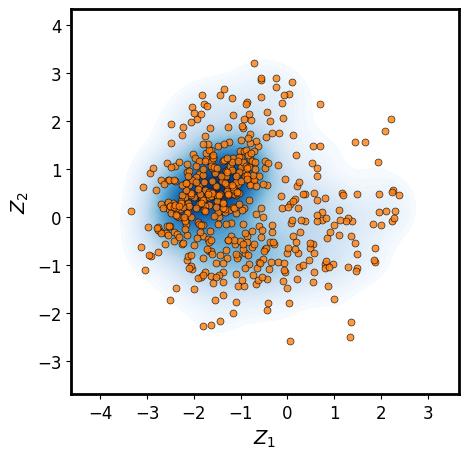

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

z_mean_std, z_std = vae_vanilla.encode(vae_data)
# Creating a figure with seaborn
plt.figure(figsize=(5, 5), facecolor='white')



# KDE plot
sns.kdeplot(x=z_mean_std[:, -1], y=z_mean_std[:, -2], cmap="Blues", levels = 50, shade=True)

# Scatter plot
sc = plt.scatter(z_mean_std[:, -1], z_mean_std[:, -2],  s=25, alpha = 0.8, edgecolor='k', linewidth=0.5)


# Adding labels and title
plt.xlabel("$Z_1$", fontsize=14)
plt.ylabel("$Z_2$", fontsize=14)
# plt.title("Scatter Plot of Latent Variables with KDE", fontsize=16, pad=15)



# Increasing size of ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


# Displaying the plot
plt.show()


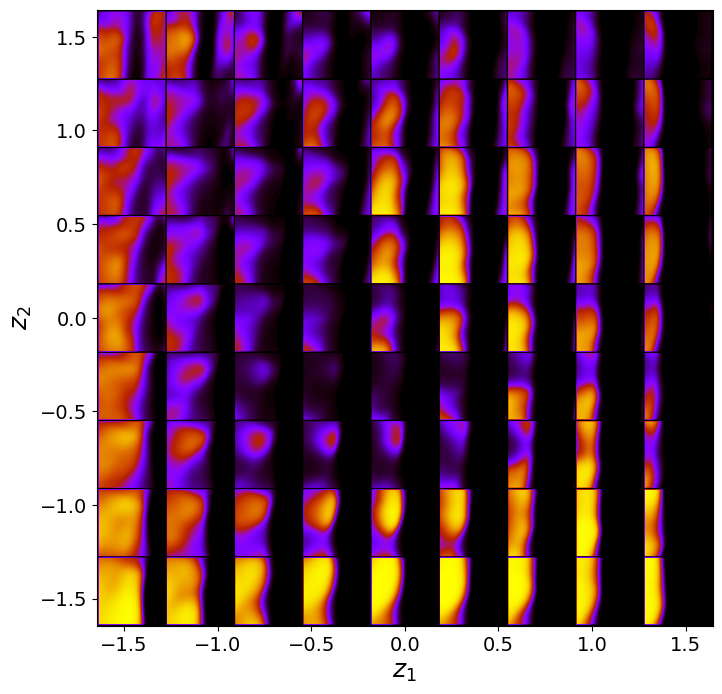

tensor([[[1.5611e-01, 1.5896e-01, 1.6262e-01,  ..., 4.9641e-01,
          4.8856e-01, 4.8123e-01],
         [1.6088e-01, 1.6338e-01, 1.6671e-01,  ..., 4.9795e-01,
          4.8869e-01, 4.7990e-01],
         [1.6641e-01, 1.6852e-01, 1.7148e-01,  ..., 4.9853e-01,
          4.8796e-01, 4.7784e-01],
         ...,
         [6.1722e-01, 6.2807e-01, 6.3929e-01,  ..., 5.1830e-01,
          5.4703e-01, 5.7412e-01],
         [6.1911e-01, 6.3022e-01, 6.4167e-01,  ..., 5.2594e-01,
          5.5446e-01, 5.8110e-01],
         [6.2094e-01, 6.3229e-01, 6.4395e-01,  ..., 5.3359e-01,
          5.6181e-01, 5.8791e-01]],

        [[2.0841e-01, 2.1973e-01, 2.3213e-01,  ..., 5.2270e-01,
          5.5765e-01, 5.9056e-01],
         [2.1048e-01, 2.2125e-01, 2.3306e-01,  ..., 5.1169e-01,
          5.4429e-01, 5.7493e-01],
         [2.1376e-01, 2.2395e-01, 2.3516e-01,  ..., 5.0050e-01,
          5.3054e-01, 5.5865e-01],
         ...,
         [5.1304e-01, 5.2761e-01, 5.4120e-01,  ..., 3.5184e-02,
          3.596

In [ ]:
vae_vanilla.manifold2d(d = 9) # sigma = 0.6

# SI-VAE
This section contains functions for plotting the latent space from the VAE

In [ ]:
# plotting utility
from pyroved.utils import generate_latent_grid, plot_img_grid
from typing import Optional, Tuple, Union, List
from typing import Union, List, Tuple
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os


#*****************************************************manifold2d
def plot_img_grid_custom(imgdata: torch.Tensor, d: int, ws: int,
                  **kwargs: Union[str, int, List[float]]) -> None:
    """
    Plots a *d*-by-*d* square grid of 2D images
    """


    if imgdata.ndim < 3:
        raise AssertionError("Images must be passed as a 3D or 4D tensor")
    imgdata = imgdata[:, None] if imgdata.ndim == 3 else imgdata
    grid = make_grid(imgdata, nrow=d,
                     padding=kwargs.get("padding", 2),
                     pad_value=kwargs.get("pad_value", 0)).cpu()
    extent = kwargs.get("extent")
    # Put on cpu in case all tensors are created on gpu by default
    extent_ = [e.cpu() for e in extent]
    plt.figure(figsize=(6, 6), dpi = 100)
    plt.imshow(grid[0].squeeze(), cmap=kwargs.get("cmap", "gnuplot"),
               origin=kwargs.get("origin", "upper"),
               extent=extent_)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.text(-1.75, 1.75, f'ω: {ws}', fontsize=14, verticalalignment='top', color='white',
        bbox=dict(boxstyle="round", facecolor='black', edgecolor='none'))
    plt.xlabel("$z_1$", fontsize=18)
    plt.ylabel("$z_2$", fontsize=18)
    # plt.tight_layout()

    # plt.title(f"2dmanifold_window_size{ws}", fontsize=20)
    plt.savefig(f"manifold/2dmanifold_window_size{ws}")
    plt.show()


def get_custom_manifold2d(local_vae, d: int, ws=1):
    """
    Plots a learned latent manifold in the data space

    Args:
        d: Grid size
        plot: Plots the generated manifold (Default: True)
        y: Conditional "property" vector (e.g. one-hot encoded class vector)
        kwargs: Keyword arguments include custom min/max values
                for grid boundaries passed as 'z_coord'
                (e.g. z_coord = [-3, 3, -3, 3]), 'angle' and
                'shift' to condition a generative model on, and plot parameters
                ('padding', 'pad_value', 'cmap', 'origin', 'ylim')
    """
    os.makedirs("manifold", exist_ok=True)
    z, (grid_x, grid_y) = generate_latent_grid(d, z_coord = [-2,2,-2,2])
    z = [z]

    loc = local_vae.decode(*z, )

    plot_img_grid_custom(
                loc, d,ws = ws,
                extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()])



    return loc


#**************************************************************************latent representation with KDE

def plot_latent_rep_with_kde(z_mean, z_sd, ws, folder):
    # Set up the figure size and DPI
    fig, ax = plt.subplots(figsize=(4, 5), dpi=200)

    # Make directory if it does not exist
    os.makedirs(folder, exist_ok=True)

    # Scatter plot
    im = ax.scatter(z_mean[:, -2], z_mean[:, -1], s=6, c='b', edgecolors='black', linewidths=0.5, alpha=1)

    # Set aspect ratio to be equal
    ax.set_aspect('equal')

    # Attempt to create a KDE plot
    try:
        sns.kdeplot(x=z_mean[:, -2], y=z_mean[:, -1], fill=True, thresh=0.01, levels=50, cmap="autumn", ax=ax, alpha=0.3)
    except ValueError:
        print("kde -didn't work")

    # Set x and y limits
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])

    # Set labels
    ax.set_xlabel("$Z_1$", fontsize=12)
    ax.set_ylabel("$Z_2$", fontsize=12)

    # Add text or annotations
    ax.text(-4.5, 4.5, f'ω: {ws}', fontsize=12, verticalalignment='top', color='black')

    # Automatically adjust subplot parameters
    plt.tight_layout()

    # Save the figure with a tight bounding box
    plt.savefig(f"{folder}/latent_distribution_window_size{ws}.png", bbox_inches='tight')

#****************************************plot latent images


#****************************************plot features on atoms images

def visualize_on_patches_latent_images(spm_image_stack, frames_all, frame, z1, z2, z3, filtered_coordinates, ws, folder):
    """
    Visualizes the latent space encodings on the raw STEM image for a given frame.

    Parameters:
    - image
    - z1: Feature set one interested in
    - z2: Feature set two interested in

    Returns:
    - None: Displays a matplotlib figure with the visualization.
    """

    spm_image = spm_image_stack[frame]
    os.makedirs(folder, exist_ok=True)
    com_i = filtered_coordinates
    col_min0 = z1.min()
    col_max0 = z1.max()
    col_min1 = z2.min()
    col_max1 = z2.max()
    z1_i = z1[frames_all == frame]
    z2_i = z2[frames_all == frame]
    z3_i = z3[frames_all == frame]

    col_min2 = z3.min()
    col_max2 = z3.max()

    fig, ax = plt.subplots(1, 3, figsize=(30, 10))
    # fig, ax = plt.subplots(1, 2, figsize=(30, 10))
    ax[0].imshow(spm_image)
    ax[0].scatter(com_i[:,1],com_i[:,0], c=z1_i, s=15,
                  cmap="jet", vmin=col_min0, vmax=col_max0)
    ax[0].set_title("Angle Encoding", fontsize=18)
    ax[0].axis('off')


    ax[1].imshow(spm_image)
    ax[1].scatter(com_i[:,1],com_i[:,0], c=z2_i, s=15,
                  cmap="jet", vmin=col_min0, vmax=col_max0)
    ax[1].set_title("Latent variable 1", fontsize=18)
    ax[1].axis('off')

    ax[2].imshow(spm_image)
    ax[2].scatter(com_i[:,1],com_i[:,0], c=z3_i, s=15,
                  cmap="jet", vmin=col_min0, vmax=col_max0)
    ax[2].set_title("Latent variable 2", fontsize=18)
    ax[2].axis('off')

    cbar = ax[0].figure.colorbar(ax[0].collections[0], ax=ax[0], orientation='vertical', shrink = 0.7)
    cbar.set_label('Angle encoding', rotation=270, labelpad=16, fontsize = 16)
    cbar = ax[1].figure.colorbar(ax[1].collections[0], ax=ax[1], orientation='vertical', shrink = 0.7)
    cbar.set_label('latent variable 1', rotation=270, labelpad=16, fontsize = 16)
    cbar = ax[2].figure.colorbar(ax[2].collections[0], ax=ax[2], orientation='vertical', shrink = 0.7)
    cbar.set_label('latent variable 2', rotation=270, labelpad=16, fontsize = 16)
    plt.show()
    fig.suptitle(f"vizualize_latent_variables_on_patches", fontsize=20)
    plt.savefig(f"{folder}/vizualize_features_on_patches{ws}.png")



# Example of calling the function:
# visualize_latent_encodings(frame, com_all, frames_all, lattice_coord, z1, z3, STEM_real)


# Example of calling the function:
# visualize_latent_encodings(frame, com_all, frames_all, lattice_coord, z1, z3, STEM_real)


In [ ]:
def calculate_dispersion(latent_vars):
  """
  Calculates the mean and variance (dispersion) of latent variables.

  Args:
      latent_vars (numpy.ndarray): Array containing latent variables (data points x dimensions).

  Returns:
      tuple: A tuple containing the mean vector and variance array.
  """
  mean_latent_vector = np.mean(latent_vars, axis=0)
  variance = np.var(latent_vars, axis=0)
  return mean_latent_vector, variance

def calculate_dispersion_per_frame(latent_vars, frames_all):
  """
  Calculates the mean and variance of latent variables for each frame.

  Args:
      latent_vars (numpy.ndarray): Array containing latent variables (data points x dimensions).
      frames_all (list or array): List or array indicating the frame number for each data point.

  Returns:
      list: A list containing tuples of (mean_vector, variance_array) for each frame.
  """
  dispersions_per_frame = []
  for frame in np.unique(frames_all):
    frame_data = latent_vars[frames_all == frame]  # Select data points for the current frame
    mean_vector, variance_array = calculate_dispersion(frame_data)
    # dispersions_per_frame.append((mean_vector, variance_array))
  return mean_vector, variance_array


In [ ]:
# utilitily function called at each epoch for data curation
# This will maintain the patch size to be constant, which is required for VAE to train properly
import cv2

def resize_image_stack(imstack, size=(40, 40)):
    """
    Resize each image in each image stack within the given list of image stacks.
    """
    resized_imstack = np.array([cv2.resize(img, size, interpolation=cv2.INTER_LINEAR) for img in imstack])
    return resized_imstack

def get_data_loader(image_stack, batch_size = 512):
  final_train = tt(image_stack)
  final_trainloader = pv.utils.init_dataloader(final_train, batch_size=batch_size)
  return final_train, final_trainloader



## Running VAE

In [ ]:
window_size_consistent = 40 # this is the size chosen to keep the patch size consistent before entering the encoder
# Ititialize model
in_dim = (window_size_consistent, window_size_consistent)
rvae_super = pv.models.iVAE(in_dim, latent_dim=2,   # Number of latent dimensions other than the invariancies
                               hidden_dim_e = [128, 128],   # corresponds to the number of neurons in the hidden layers of the encoder
                               hidden_dim_d = [128, 128],   # corresponds to the number of neurons in the hidden layers of the decoder
                               invariances= ['r', 't'], seed=0, sampler_d = 'continuous_bernoulli')

# future addition: like STEM counter part add rtVAE option-> should be trivial
# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(rvae_super)


In [ ]:
ws = np.arange(10, 80, 1) # define what window sizes need to be cropped from our patches

In [ ]:
# np.savez("frame_number_patches.npz", f_num= np.array(f_num))

In [ ]:
array_evolution = []
co_ords = get_coordinates_single_patch(resized_ht, ws)
for i,j in tqdm(enumerate(ws)):
    print("data curation started")
    patches, f_num = get_uniform_patches(resized_ht, co_ords, j)

    patches = normalize(np.squeeze(patches))

    print(f"Number of patches: {patches.shape[0]}")
    resized_imstack = resize_image_stack(patches, size=(40, 40))
    final_train, final_trainloader = get_data_loader(resized_imstack, batch_size = 100) # original batch_size = 512
    print("data curation ended")
    print("window_size", j)
    for e in range(100):
        trainer.step(final_trainloader, scale_factor=3)
        trainer.print_statistics()


    z_mean, z_sd = rvae_super.encode(final_train)
    array_evolution.append(z_mean)
    # plot latent manifold:
    get_custom_manifold2d(rvae_super,d = 9, ws = j);   # d corresponds to the number of points sampled in each latent dimension
    # plot latent rep
    plot_latent_rep_with_kde(z_mean, z_sd, ws = j, folder = "dist")
    # plot latent images
    z1, z2, z3 = z_mean[:,0], z_mean[:, -2], z_mean[:, -1] #--> if 3 latent dim
    # visualize_on_patches_latent_images(resized_ht, f_num, 1, z1, z2, z3, co_ords[0], ws = j, folder = "latent_img")
    #visualize_on_patches_latent_images(resized_ht, f_num, 1, z1, z2, z3, co_ords[0], ws = j, folder = "latent_img")
    # visualize_on_patches_latent_images(resized_ht[19], z1, z2, co_ords, ws = j, folder = "latent_img")
    # visualize_latent_images(2, com_all, frames_all, lattice_coord, z1, z3, STEM_real, ws =j)
    # visualize_latent_images(4, com_all, frames_all, lattice_coord, z1, z3, STEM_real, ws =j)

Output hidden; open in https://colab.research.google.com to view.

The SI-VAE took 19 minutes to run, but it captures the variation of features across different length scales and we don't have to go through different iterations to select a descriptor.

In [ ]:
from google.colab import files

In [ ]:
# Save the weights to use for the running VAE
rvae_super.save_weights(f"PTO_10um_weight_running_VAE")

In [ ]:
# files.download(f"/content/PTO_20240605/PTO_10um_weight_running_VAE.pt")

In [ ]:
# array_evolution contains all the latent distribution invofmation and this can be used for post processing
np.savez("array_evolution_PTO_10um_running_VAE.npz", array_evolution= np.array(array_evolution))

In [ ]:
# files.download(f"/content/PTO_20240605/array_evolution_PTO_10um_running_VAE.npz")

## Now postprocessing evolution of window size for Running VAE

In [ ]:
array_evolution = np.load("/content/PTO_20240605/array_evolution_PTO_10um_running_VAE.npz")["array_evolution"]
array_evolution.shape

(70, 484, 5)

Text(0.5, 1.0, 'Evolution of Angle encoding for all Patches')

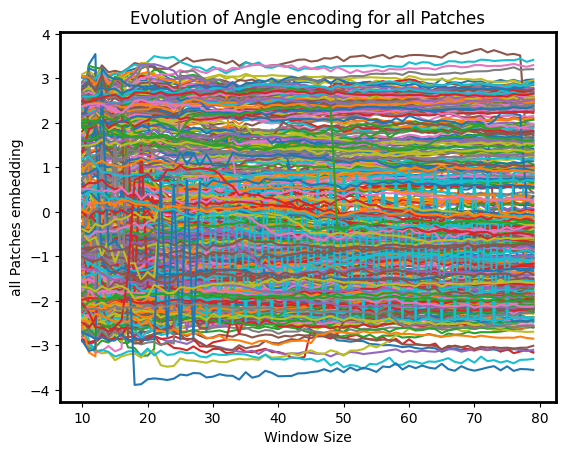

In [ ]:
plt.plot(ws, array_evolution[:,:,0]);
plt.xlabel("Window Size")
plt.ylabel("all Patches embedding")
# Adding a title to the plot
plt.title("Evolution of Angle encoding for all Patches")

Text(0.5, 1.0, 'Evolution of Translation-X for all Patches')

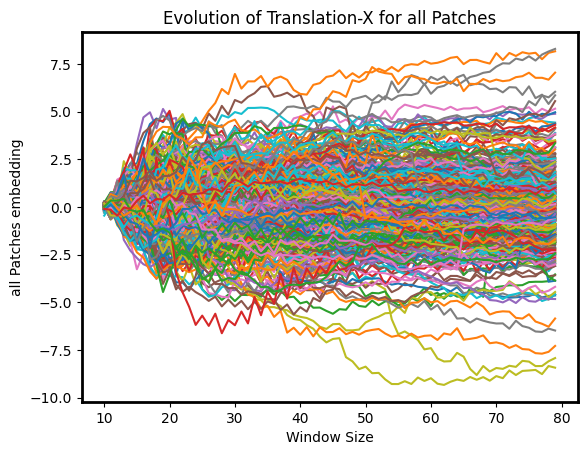

In [ ]:
plt.plot(ws, array_evolution[:,:,1]);
plt.xlabel("Window Size")
plt.ylabel("all Patches embedding")
# Adding a title to the plot
plt.title("Evolution of Translation-X for all Patches")

Text(0.5, 1.0, 'Evolution of Translation-Y for all Patches')

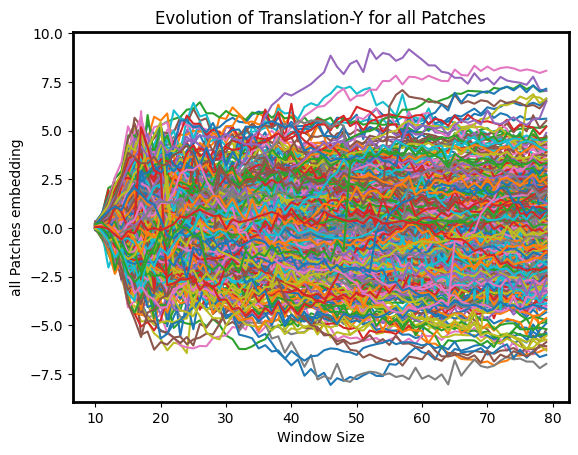

In [ ]:
plt.plot(ws, array_evolution[:,:,2]);
plt.xlabel("Window Size")
plt.ylabel("all Patches embedding")
# Adding a title to the plot
plt.title("Evolution of Translation-Y for all Patches")

Text(0.5, 1.0, 'Evolution of 1st Latent Variables for all Patches')

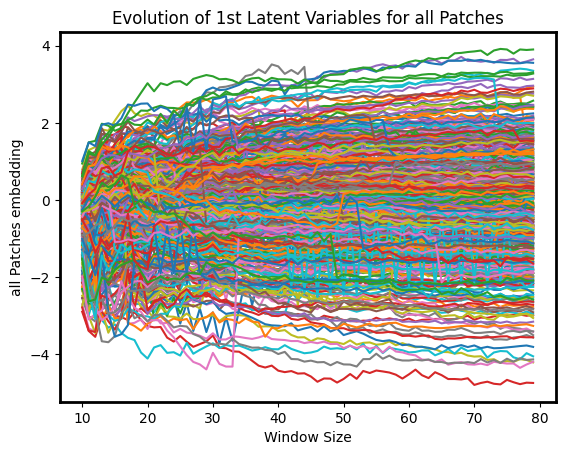

In [ ]:
plt.plot(ws, array_evolution[:,:,3]);
plt.xlabel("Window Size")
plt.ylabel("all Patches embedding")
# Adding a title to the plot
plt.title("Evolution of 1st Latent Variables for all Patches")

Text(0.5, 1.0, 'Evolution of 2nd Latent Variables for all Patches')

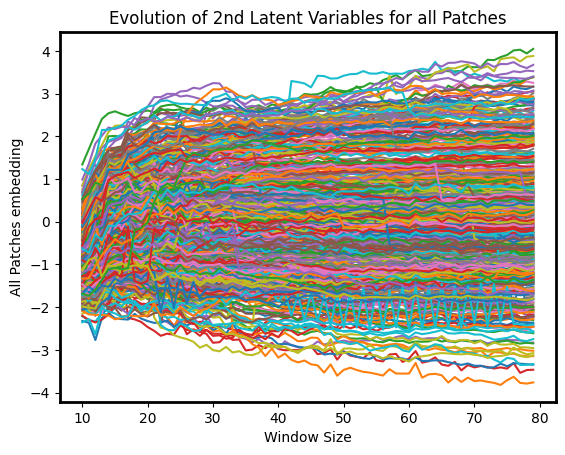

In [ ]:
plt.plot(ws, array_evolution[:,:,4]);
plt.xlabel("Window Size")
plt.ylabel("All Patches embedding")
# Adding a title to the plot
plt.title("Evolution of 2nd Latent Variables for all Patches")

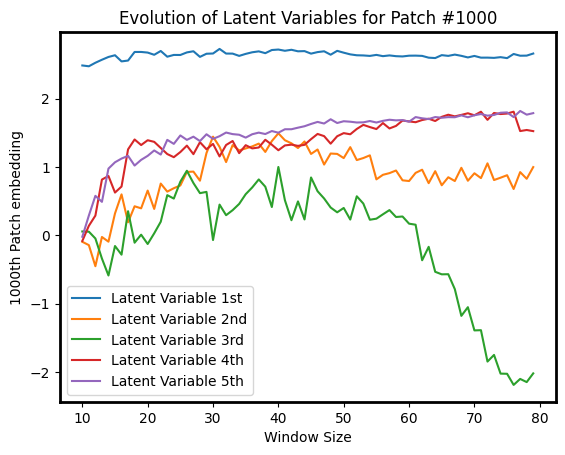

In [ ]:
# plot evolution of the 1000th atom
chosen_atom = 484
latent_variable_labels = ['1st', '2nd', '3rd', '4th', '5th']

for i in range(5):
    plt.plot(ws, array_evolution[:, chosen_atom - 1, i], label=f"Latent Variable {latent_variable_labels[i]}")

# Labeling the axes
plt.xlabel("Window Size")
plt.ylabel("1000th Patch embedding")

# Adding a legend
plt.legend(loc='best')

# Adding a title to the plot
plt.title("Evolution of Latent Variables for Patch #1000")

# Show the plot
plt.show()


## optional - make video

In [ ]:
import cv2
import os
def create_video_recursive(base_folder, fps=2, frame_size=(640, 480), extension=".png", name = "video"):
    """
    Recursively creates video files from sequences of images in subfolders.

    Args:
        base_folder (str): The path to the base folder from where to start the recursive process.
        fps (int, optional): The frame rate of the output video. Defaults to 30.
        frame_size (tuple, optional): The size of the output video frames as a tuple of (width, height) in pixels. Defaults to (640, 480).
        extension (str, optional): The file extension of the image files to include in the video. Defaults to ".png".

    Returns:
        None
    """

    for folder_path, _, _ in os.walk(base_folder):
        # Get a list of all the image files in the current folder
        file_list = [f for f in os.listdir(folder_path) if f.endswith(extension)]


        if not file_list:
            continue

        output_file = os.path.join(folder_path, f"{os.path.basename(folder_path)}{name}.avi")
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(output_file, fourcc, fps, frame_size)

        for file_name in sorted(file_list):  # Sorting to ensure images are processed in order
            # Read the image file
            img = cv2.imread(os.path.join(folder_path, file_name))

            # Resize the image to the output size
            img = cv2.resize(img, frame_size)

            # Write the image to the output video
            out.write(img)

        # Release the VideoWriter object
        out.release()

In [ ]:
create_video_recursive("/content/PTO_20240605/manifold", fps = 5,frame_size = (1000,1000), name = "manifold_PTO_10um_20epoch_fullVAE")

In [ ]:
# files.download(f"/content/PTO_20240605/manifold/manifoldmanifold_PTO_10um_20epoch_fullVAE.avi")

In [ ]:
!zip -r /content/manifold.zip /content/PTO_20240605/manifold

In [ ]:
# files.download(f"/content/manifold.zip")

In [ ]:
create_video_recursive("/content/PTO_20240605/dist", fps = 5, frame_size = (1500,1200), name = "dist_PTO_10um_20epoch_fullVAE")

In [ ]:
# files.download(f"/content/PTO_20240605/dist/distdist_PTO_10um_20epoch_fullVAE.avi")

In [ ]:
!zip -r /content/dist.zip /content/PTO_20240605/dist

In [ ]:
files.download(f"/content/dist.zip")

In [ ]:
create_video_recursive("/content/latent_img/", name = "latent_img_WTV")

In [ ]:
!zip -r /content/latent_img.zip /content/latent_img

## Optional Analysis : PCA on KDE of the latent distribution

In [ ]:
array_evolution.shape

(70, 484, 5)

In [ ]:
l1 = array_evolution[:,:,-2]
l2 = array_evolution[:,:,-1]
print(f"Z1.shape is {l1.shape}")
print(f"Z2.shape is {l2.shape}")

Z1.shape is (70, 484)
Z2.shape is (70, 484)


In [ ]:
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Compute KDEs for each window size
kde_results = []
for i in range(l1.shape[0]):
    data = np.vstack([l1[i, :], l2[i, :]])
    kde = gaussian_kde(data)
    grid_x, grid_y = np.mgrid[data[0].min():data[0].max():100j, data[1].min():data[1].max():100j]
    kde_results.append(kde(np.vstack([grid_x.ravel(), grid_y.ravel()])).reshape(grid_x.shape))

# Step 2 & 3: Flatten, PCA and Reshape
kde_matrix = np.array([kde_result.ravel() for kde_result in kde_results])
pca = PCA(n_components=5)  # Adjust components as needed
pca_results = pca.fit_transform(kde_matrix)

# Reshape PCA results for visualization
pca_components = pca.components_.reshape(-1, 100, 100)
pca_loadings = pca.transform(kde_matrix)


In [ ]:
#Display the KDE for each window size
import math

total_plots = array_evolution.shape[0]
# Find a nearly square layout
num_columns = math.ceil(math.sqrt(total_plots))
num_rows = math.ceil(total_plots / num_columns)
fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns*3, num_rows*3), dpi = 300)
axes = axes.ravel()

for w in range(total_plots):
    ax = axes[w]
    im = ax.imshow(kde_results[w], cmap='viridis')
    ax.set_title(f'Window Size {ws[w]}')
    ax.axis('off')

plt.tight_layout()

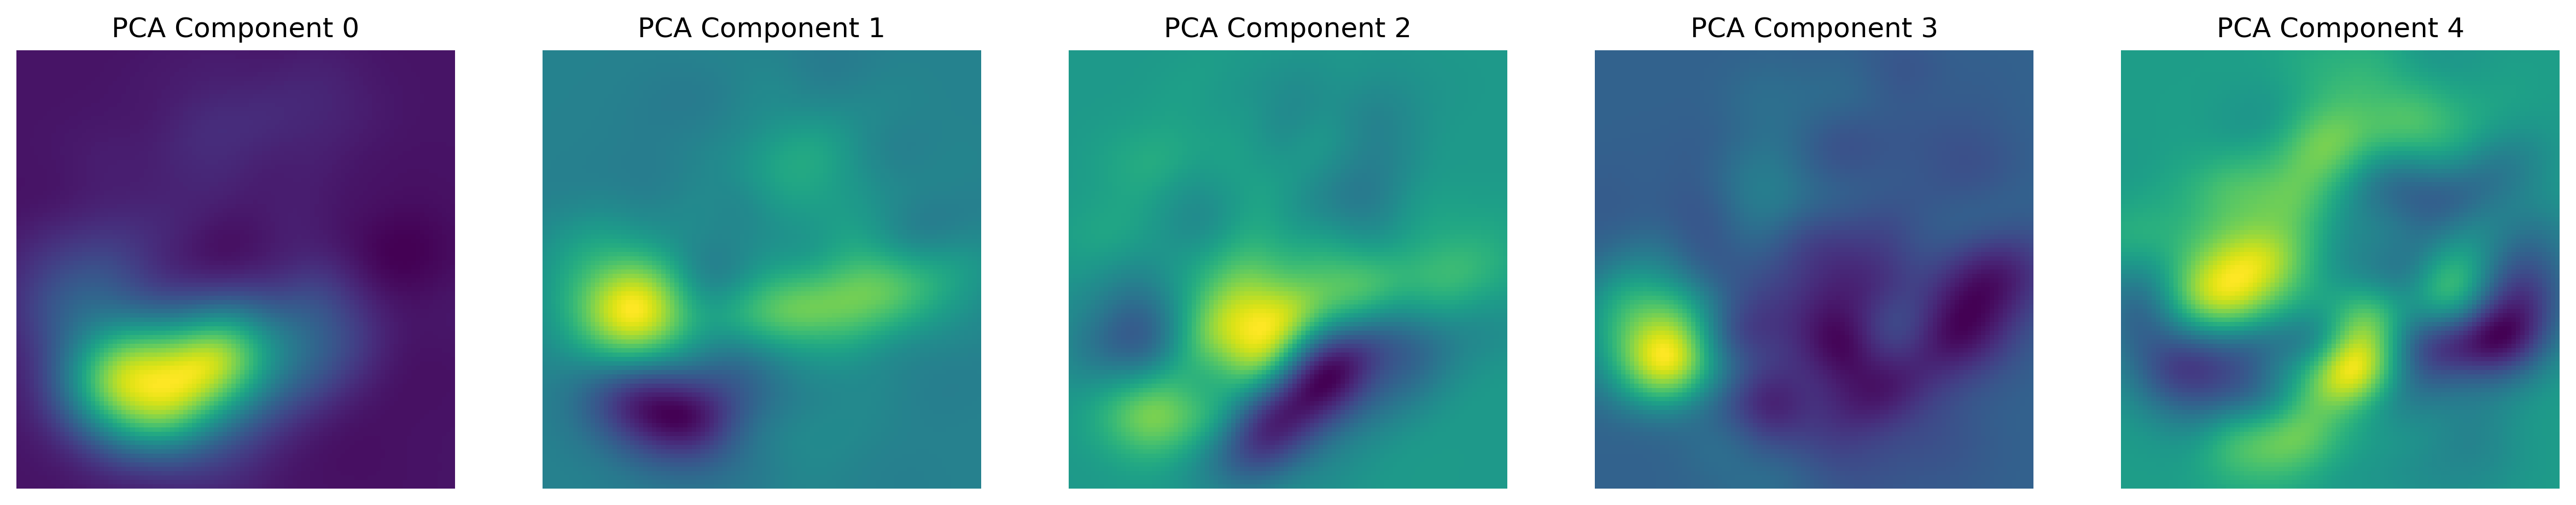

In [ ]:
#Display all 5 PCA components

fig, axes = plt.subplots(1, 5, figsize=(20, 28), dpi = 300)
axes = axes.ravel()

for n in range(5):
    ax = axes[n]
    im = ax.imshow(pca_components[n], cmap='viridis')
    ax.set_title(f'PCA Component {n}')
    ax.axis('off')

Text(0.5, 1.0, 'Loadings Map')

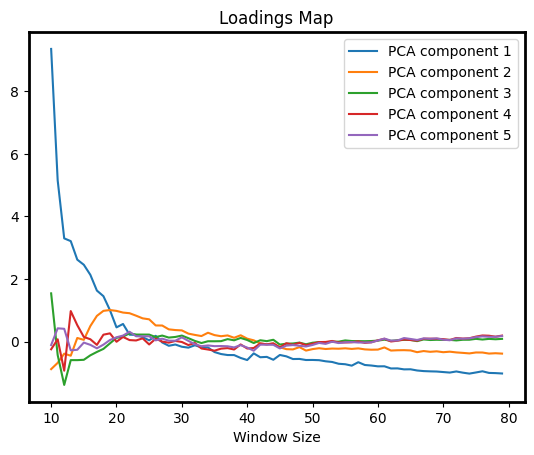

In [ ]:
for i in range(5):
  plt.plot(ws,pca_loadings[:,i], label = f"PCA component {i+1}")
plt.legend()
plt.xlabel("Window Size")
plt.title("Loadings Map")

#Full VAE

In [ ]:
window_size_consistent = 40
# Ititialize model
in_dim = (window_size_consistent, window_size_consistent)
rvae_super = pv.models.iVAE(in_dim, latent_dim=2,   # Number of latent dimensions other than the invariancies
                               hidden_dim_e = [128, 128],   # corresponds to the number of neurons in the hidden layers of the encoder
                               hidden_dim_d = [128, 128],   # corresponds to the number of neurons in the hidden layers of the decoder
                               invariances= ['r', 't'], seed=0, sampler_d = 'continuous_bernoulli')

# future addition: like STEM counter part add rtVAE option-> should be trivial
# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(rvae_super)


In [ ]:
rvae_super.load_weights("/content/PTO_20240605/PTO_10um_weight_running_VAE.pt")

In [ ]:
array_evolution = []
co_ords = get_coordinates_single_patch(resized_ht, ws)
for i,j in tqdm(enumerate(ws)):
    print("data curation started")
    patches, f_num = get_uniform_patches(resized_ht, co_ords, j)

    patches = normalize(np.squeeze(patches))

    print(f"Number of patches: {patches.shape[0]}")
    resized_imstack = resize_image_stack(patches, size=(40, 40))
    final_train, final_trainloader = get_data_loader(resized_imstack, batch_size = 100) # original batch_size = 512
    print("data curation ended")
    print("window_size", j)

    z_mean, z_sd = rvae_super.encode(final_train)
    array_evolution.append(z_mean)
    # plot latent manifold:
    get_custom_manifold2d(rvae_super,d = 9, ws = j);   # d corresponds to the number of points sampled in each latent dimension
    # plot latent rep
    plot_latent_rep_with_kde(z_mean, z_sd, ws = j, folder = "dist")
    # plot latent images
    z1, z2, z3 = z_mean[:,0], z_mean[:, -2], z_mean[:, -1] #--> if 3 latent dim
    # visualize_on_patches_latent_images(resized_ht, f_num, 1, z1, z2, z3, co_ords[0], ws = j, folder = "latent_img")
    #visualize_on_patches_latent_images(resized_ht, f_num, 1, z1, z2, z3, co_ords[0], ws = j, folder = "latent_img")
    # visualize_on_patches_latent_images(resized_ht[19], z1, z2, co_ords, ws = j, folder = "latent_img")
    # visualize_latent_images(2, com_all, frames_all, lattice_coord, z1, z3, STEM_real, ws =j)
    # visualize_latent_images(4, com_all, frames_all, lattice_coord, z1, z3, STEM_real, ws =j)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
np.savez("array_evolution_PTO_10um_fullVAE.npz", array_evolution= np.array(array_evolution))

In [ ]:
files.download(f"/content/PTO_20240605/array_evolution_PTO_10um_fullVAE.npz")

## Now postprocessing evolution of window size for Full VAE

In [ ]:
array_evolution = np.load("/content/PTO_20240605/array_evolution_PTO_10um_fullVAE.npz")["array_evolution"]
array_evolution.shape

(70, 484, 5)

Text(0.5, 1.0, 'Evolution of 1st Latent Variables for all Patches')

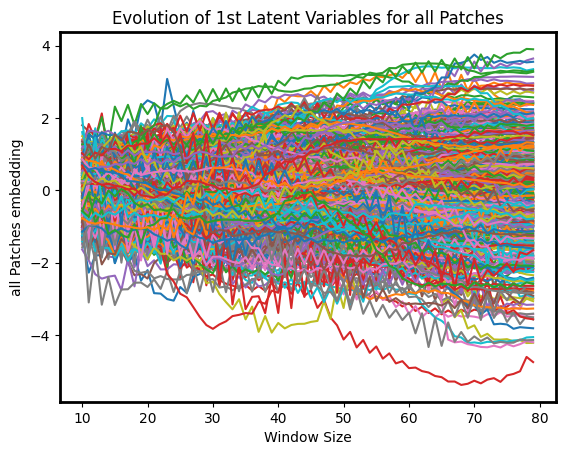

In [ ]:
plt.plot(ws, array_evolution[:,:,3]);
plt.xlabel("Window Size")
plt.ylabel("all Patches embedding")
# Adding a title to the plot
plt.title("Evolution of 1st Latent Variables for all Patches")

Text(0.5, 1.0, 'Evolution of 2nd Latent Variables for all Patches')

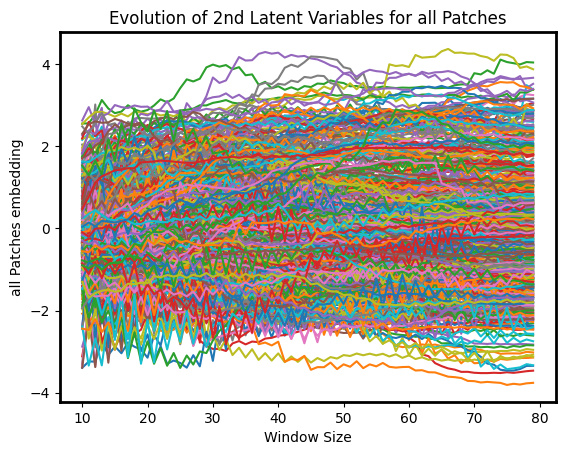

In [ ]:
plt.plot(ws, array_evolution[:,:,4]);
plt.xlabel("Window Size")
plt.ylabel("all Patches embedding")
# Adding a title to the plot
plt.title("Evolution of 2nd Latent Variables for all Patches")

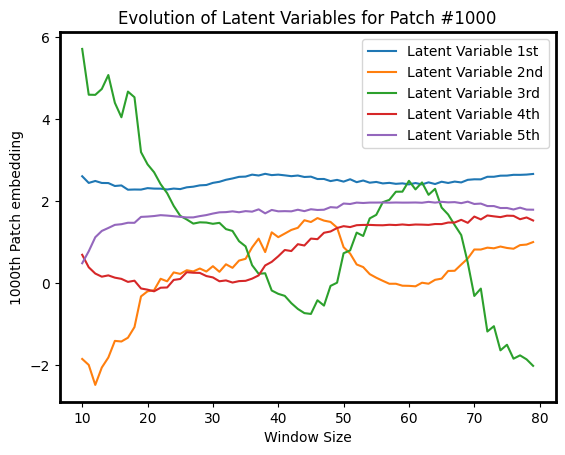

In [ ]:
# plot evolution of the 1000th atom
chosen_atom = 484
latent_variable_labels = ['1st', '2nd', '3rd', '4th', '5th']

for i in range(5):
    plt.plot(ws, array_evolution[:, chosen_atom - 1, i], label=f"Latent Variable {latent_variable_labels[i]}")

# Labeling the axes
plt.xlabel("Window Size")
plt.ylabel("1000th Patch embedding")

# Adding a legend
plt.legend(loc='best')

# Adding a title to the plot
plt.title("Evolution of Latent Variables for Patch #1000")

# Show the plot
plt.show()


## optional - make video

In [ ]:
import cv2
import os
def create_video_recursive(base_folder, fps=2, frame_size=(640, 480), extension=".png", name = "video"):
    """
    Recursively creates video files from sequences of images in subfolders.

    Args:
        base_folder (str): The path to the base folder from where to start the recursive process.
        fps (int, optional): The frame rate of the output video. Defaults to 30.
        frame_size (tuple, optional): The size of the output video frames as a tuple of (width, height) in pixels. Defaults to (640, 480).
        extension (str, optional): The file extension of the image files to include in the video. Defaults to ".png".

    Returns:
        None
    """

    for folder_path, _, _ in os.walk(base_folder):
        # Get a list of all the image files in the current folder
        file_list = [f for f in os.listdir(folder_path) if f.endswith(extension)]


        if not file_list:
            continue

        output_file = os.path.join(folder_path, f"{os.path.basename(folder_path)}{name}.avi")
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(output_file, fourcc, fps, frame_size)

        for file_name in sorted(file_list):  # Sorting to ensure images are processed in order
            # Read the image file
            img = cv2.imread(os.path.join(folder_path, file_name))

            # Resize the image to the output size
            img = cv2.resize(img, frame_size)

            # Write the image to the output video
            out.write(img)

        # Release the VideoWriter object
        out.release()

In [ ]:
create_video_recursive("/content/PTO_20240605/manifold", fps = 5,frame_size = (1000,1000), name = "manifold_PTO_10um_20epoch_fullVAE")

In [ ]:
# files.download(f"/content/PTO_20240605/manifold/manifoldmanifold_PTO_10um_20epoch_fullVAE.avi")

In [ ]:
!zip -r /content/manifold.zip /content/PTO_20240605/manifold

In [ ]:
# files.download(f"/content/manifold.zip")

In [ ]:
create_video_recursive("/content/PTO_20240605/dist", fps = 5, frame_size = (1500,1200), name = "dist_PTO_10um_20epoch_fullVAE")

In [ ]:
# files.download(f"/content/PTO_20240605/dist/distdist_PTO_10um_20epoch_fullVAE.avi")

In [ ]:
!zip -r /content/dist.zip /content/PTO_20240605/dist

In [ ]:
# files.download(f"/content/dist.zip")

In [ ]:
create_video_recursive("/content/latent_img/", name = "latent_img_WTV")

In [ ]:
!zip -r /content/latent_img.zip /content/latent_img

## Optional Analysis : PCA on KDE of the latent distribution

In [ ]:
array_evolution.shape

(70, 484, 5)

In [ ]:
l1 = array_evolution[:,:,-2]
l2 = array_evolution[:,:,-1]
print(f"Z1.shape is {l1.shape}")
print(f"Z2.shape is {l2.shape}")

Z1.shape is (70, 484)
Z2.shape is (70, 484)


In [ ]:
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Compute KDEs for each window size
kde_results = []
for i in range(l1.shape[0]):
    data = np.vstack([l1[i, :], l2[i, :]])
    kde = gaussian_kde(data)
    grid_x, grid_y = np.mgrid[data[0].min():data[0].max():100j, data[1].min():data[1].max():100j]
    kde_results.append(kde(np.vstack([grid_x.ravel(), grid_y.ravel()])).reshape(grid_x.shape))

# Step 2 & 3: Flatten, PCA and Reshape
kde_matrix = np.array([kde_result.ravel() for kde_result in kde_results])
pca = PCA(n_components=5)  # Adjust components as needed
pca_results = pca.fit_transform(kde_matrix)

# Reshape PCA results for visualization
pca_components = pca.components_.reshape(-1, 100, 100)
pca_loadings = pca.transform(kde_matrix)


In [ ]:
#Display the KDE for each window size
import math

total_plots = array_evolution.shape[0]
# Find a nearly square layout
num_columns = math.ceil(math.sqrt(total_plots))
num_rows = math.ceil(total_plots / num_columns)
fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns*3, num_rows*3), dpi = 300)
axes = axes.ravel()

for w in range(total_plots):
    ax = axes[w]
    im = ax.imshow(kde_results[w], cmap='viridis')
    ax.set_title(f'Window Size {ws[w]}')
    ax.axis('off')

plt.tight_layout()

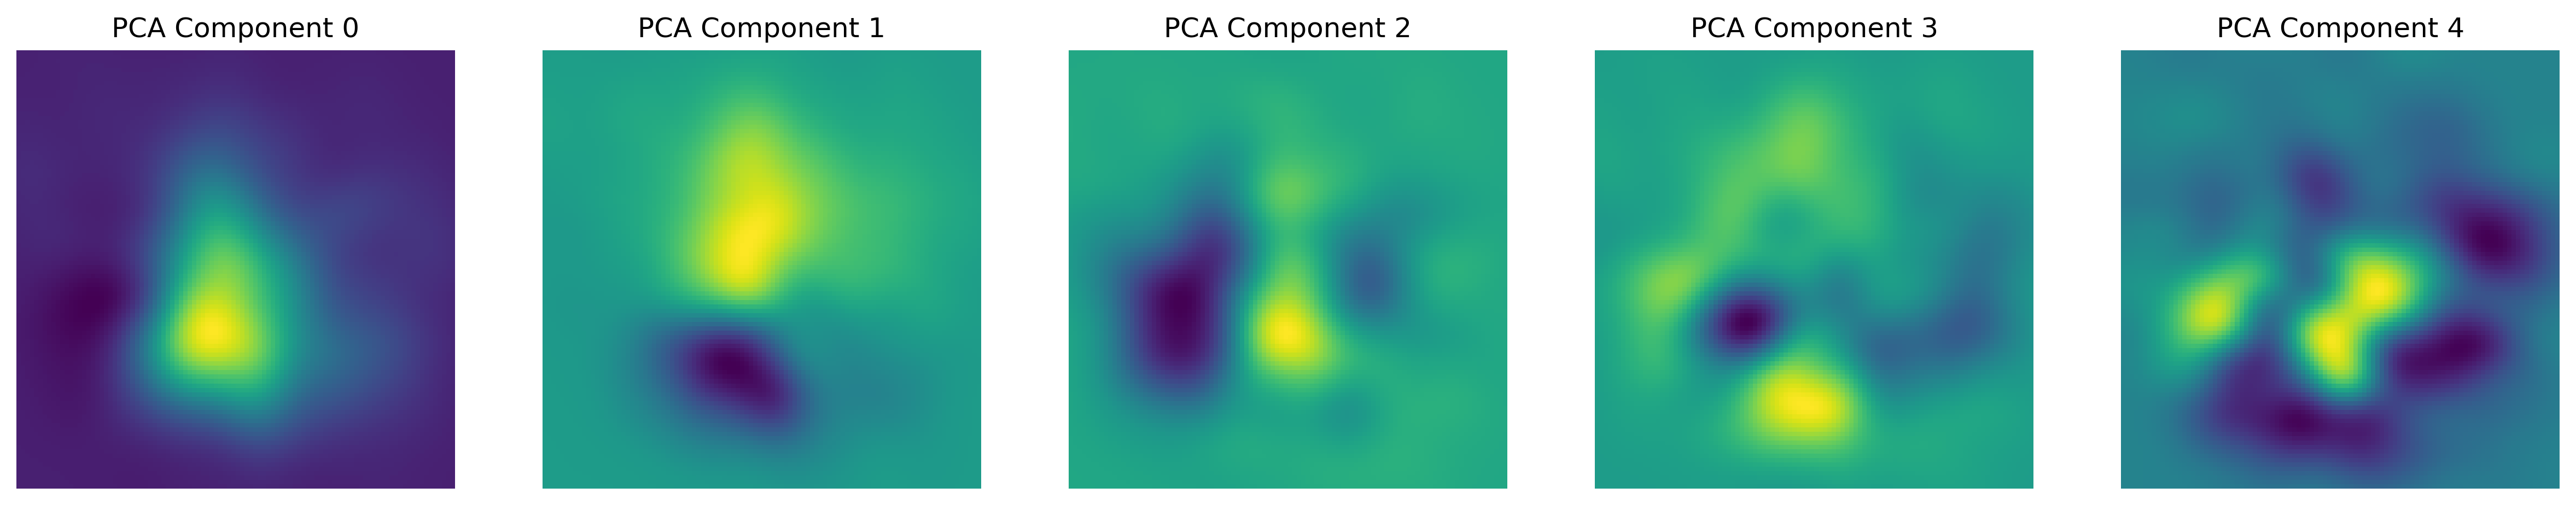

In [ ]:
#Display all 5 PCA components

fig, axes = plt.subplots(1, 5, figsize=(20, 28), dpi = 300)
axes = axes.ravel()

for n in range(5):
    ax = axes[n]
    im = ax.imshow(pca_components[n], cmap='viridis')
    ax.set_title(f'PCA Component {n}')
    ax.axis('off')

Text(0.5, 1.0, 'Loadings Map')

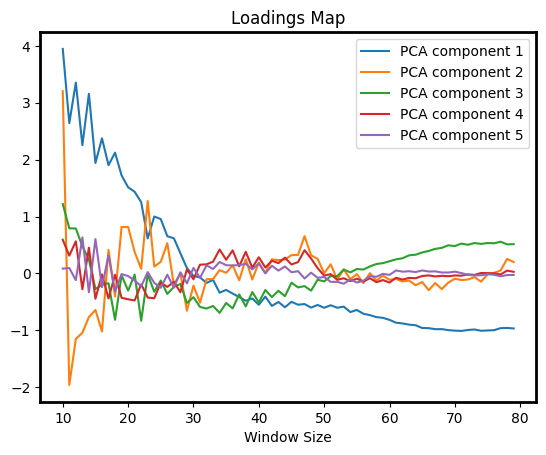

In [ ]:
for i in range(5):
  plt.plot(ws,pca_loadings[:,i], label = f"PCA component {i+1}")
plt.legend()
plt.xlabel("Window Size")
plt.title("Loadings Map")